## Predictive Model for Car Sales

**Project Objectives:**

The project aims to develop a predictive model that assists app users in determining the market value of a used car. To achieve this, the following steps will be taken:

1. Data Pre-processing
2. Exploratory Analysis
3. Data Preparation for Machine Learning
4. Model Selection and Training Algorithm
5. Training, Setting, Testing, and Checking Model Quality
6. Forecast and Conclusion

In alignment with the customer's business objectives, the project involves the creation of a predictive model to estimate car costs, addressing a linear regression problem.

The customer considers the importance of the following criteria:
- Quality of Prediction
- Model Training Time
- Model Prediction Time

**Data Source:**

The dataset provided by the customer includes information on the technical characteristics, equipment, and prices of other cars.

**Tools and libraries:**
- Python
- Pandas
- Matplotlib
- Numpy
- Sklearn
- Seaborn
- LightGBM

# Прогнозная модель для определения стоимости авто

**Аннотация проекта**

На данных сервиса по продаже автомобилей с пробегом проводится исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит компании привлечь новых клиентов.

**Цель исследования** — разработать прогнозную модель, которая поможет пользователям приложения определить рыночную стоимость своего автомобиля. Для этого будут выполнены следующие шаги:

- Предварительная обработка данных.
- Исследовательский анализ.
- Подготовка данных для машинного обучения.
- Выбор модели и алгоритма её обучения.
- Обучение, настройка, тестирование и оценка качества моделей.
- Прогноз и выводы.

Учитывая бизнес-задачи заказчика, предстоит разработать прогнозную модель для предсказания стоимости автомобиля (задача линейной регрессии).

**Критерии, которые важны заказчику:**
- качество предсказания
- время обучения модели
- время предсказания модели

Поскольку нам не известны детальные требования клиента, которые могли бы конкретизировать заказ, в частности, какие есть ресурсные ограничения на разработку модели, будем руководствоваться классическими опциями при выборе модели и алгоритма её обучения.

**Описание данных**

Датасет, представленный заказчиком, содержит данные о технических характеристиках, комплектации и ценах других автомобилей.

**Инструменты и библиотеки:**
- Python
- Pandas
- Matplotlib
- Numpy
- Sklearn
- Seaborn
- LightGBM

In [1]:
! pip install phik -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install --upgrade scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install category_encoders -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# импорт библиотек, модулей и функций
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import category_encoders as ce
import re, time
import warnings

# функция для расчёта матрицы корреляции
from phik import phik_matrix

# инструменты для пайплайн
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# функция для разделения датасета на выборки
from sklearn.model_selection import train_test_split
# классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
# класс для работы с пропусками
from sklearn.impute import SimpleImputer
# классы для моделей машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
# инструменты для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
# импорт функций для расчёта метрик
from sklearn.metrics import mean_squared_error
# модуль для создания контролируемого и воспроизводимого источника случайных чисел
from numpy.random import RandomState

In [5]:
# установим настройки для отображения всех столбцов датафрейма
pd.set_option('display.max_columns', None)

## Загрузка данных

Загрузим файл и проверим, что данные в таблице соответствуют описанию.

In [6]:
# определим функцию data_isnull_isdup() для проверки на дубликаты и пустые значения
def data_isnull_isdup(data):
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:')
    print(data.isnull().sum())

In [7]:
# считываем данные из csv-файла и сохраняем в датафрейм
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [8]:
# выведем первые пять строк
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
# рассмотрим основную информацию по датасету
print('\n\n-------------------------Основная информация о данных---------------------------------\n\n')
display(df.info())
display(df.describe())



-------------------------Основная информация о данных---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
# рассмотрим какой период охватывают данные
min_timestamp = df['DateCreated'].min()
max_timestamp = df['DateCreated'].max()

print(f"Данные охватывают период с {min_timestamp} по {max_timestamp}")

Данные охватывают период с 2014-03-10 00:00:00 по 2016-04-07 00:00:00


**Вывод:**

Основываясь на предварительном обзоре датафрейма отметим следующее:
- Таблица содержит 16 столбцов, из них три признака формата дата, 7 числовых признаков — 2 из которых также имеют отношение к дате, и 6 признаков категориального типа.
- Столбец `Price` — целевой признак, содержит количественные значения и представляет цену авто (в евро).
- Очевидно, не все признаки будут информативны для обучения модели регрессии (например `DateCrawled`, `LastSeen`, `PostalCode` и `NumberOfPictures`).
- Названия колонок следует привести к единому стилю.
- Количество значений в столбцах различается. Значит, в данных есть пропущенные значения, которые следует обратотать.
- Данные охватывают период с 2014 по 2016 год.
- Объёма данных достаточно для дальнейшего исследования.

## Предобработка данных

1. Приведём названия столбцов к змеиному регистру.
2. Удалим неинформативные признаки.
3. Проверим датасет на наличие пропусков и дубликатов.
4. При необходимости устраним аномалии.

In [11]:
# приведём названия столбцов к змеиному регистру
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in df.columns]

Для прогноза стоимости автомобиля, следующие признаки не представляют информации релевантной целям обучения модели регрессии:
- `date_crawled` — дата скачивания анкеты из базы
- `registration_month` — месяц регистрации автомобиля
- `date_created` — дата создания анкеты
- `number_of_pictures` — количество фотографий автомобиля (все значения в колонке нулевые)
- `postal_code` — почтовый индекс владельца анкеты
- `last_seen` — дата последней активности пользователя
На основе предварительного обзора данных примем решение их исключить. Кроме того, удаление указанных переменных позволит не вносить шум и не стимулировать модель находить ложные зависимости.

In [12]:
# удалим столбцы с неинформативными для модели регрессии признаками
df = df.drop(columns=[
    'date_crawled',
    'registration_month',
    'date_created',
    'number_of_pictures',
    'postal_code',
    'last_seen'
], axis=1)

После удаления неинформативных колонок, оценим наличие явных и неявных дубликатов, а также количество пропусков.

In [13]:
# вызовем функцию data_isnull_isdup() и оценим количество пропусков и дубликатов
data_isnull_isdup(df)

Количество явных дубликатов: 45040
Количество пропусков:
price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64


In [14]:
# оценим долю пропущенных значений
df.isna().mean()

price                0.000000
vehicle_type         0.105794
registration_year    0.000000
gearbox              0.055967
power                0.000000
model                0.055606
kilometer            0.000000
fuel_type            0.092827
brand                0.000000
repaired             0.200791
dtype: float64

**Вывод:**
- В датафрейме есть дубликаты, избавимся от них после обработки пропусков.
- В числовых столбцах пропусков не обнаружено.
- В пяти столбцах категориального типа обнаружено значительное количество пропусков.
- Рассмотрим столбцы более детально, чтобы определить оптимальный способ обработки пропущенных значений и аномалий.

## Исследовательский анализ данных

- Проведём исследовательский анализ всех признаков.
- Оценим их особенности для выбора корректных способов подготовки к обучению модели.

**1. Анализ категориальных признаков**

In [15]:
# рассмотрим описательные статистики по категориальным столбцам
df.describe(include='object')

,vehicle_type,gearbox,model,fuel_type,brand,repaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


In [16]:
# просмотр уникальных значений в столбцах с категориальными признаками
cat_var = df.select_dtypes(exclude='number').columns.tolist()

for col in cat_var:
    unique_values = df[col].unique()
    print(f"Уникальные значения для {col}: {unique_values}")

Уникальные значения для vehicle_type: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения для gearbox: ['manual' 'auto' nan]
Уникальные значения для model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' '

**Вывод:**
- Пропуски в категориальных столбцах обозначим строкой `unknown`, так как для них нет иной обоснованной замены.
- Унифицируем названия типов топлива **petrol** и **gasoline** в столбце `fuel_type`, так как это разные названия одного и того же топлива в разных географических местах (в т.ч. Великобритания и США).

In [17]:
# пропуски в категориальных столбцах обозначим строкой 'unknown'
df[cat_var] = df[cat_var].fillna('unknown')

In [18]:
# унифицируем названия типов топлива
df.loc[df.fuel_type == 'gasoline', 'fuel_type'] = 'petrol'

In [19]:
# избавимся от дубликатов
df = df.drop_duplicates()

In [20]:
# убедимся, что обработка проведена корректно
data_isnull_isdup(df)

Количество явных дубликатов: 0
Количество пропусков:
price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64


**2. Анализ количественных признаков**

In [21]:
# рассмотрим описательные статистики по числовым столбцам
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
price,308482.0,4491.309953,4568.212025,0.0,1100.0,2800.0,6500.0,20000.0
registration_year,308482.0,2004.364767,92.667966,1000.0,1999.0,2003.0,2008.0,9999.0
power,308482.0,111.022951,201.227700,0.0,69.0,105.0,143.0,20000.0
kilometer,308482.0,127164.242970,38563.538353,5000.0,125000.0,150000.0,150000.0,150000.0


**Вывод:**
- Минимальные и максимальные значения во всех числовых столбцах выглядят аномальными.
- Возраст, мощность и пробег автомобиля могут существенно влиять на его стоимость, поэтому для корректного обучения модели следует избавиться от таких аномалий.
- Рассмотрим данные более детально для корректной фильтрации.

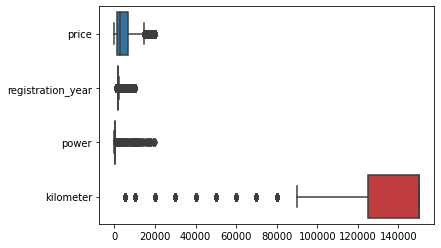

In [22]:
# список числовых признаков таблицы
num_var = df.select_dtypes(include='number').columns.tolist()

# построим диаграмму ящик с усами
sns.boxplot(data=df[num_var], orient='h')
plt.yticks(range(len(num_var)), num_var)
plt.show()

**Вывод:**
- На графике очевидны выбросы.
- Визуализируем распределение значений по каждому признаку и избавимся от аномалий.

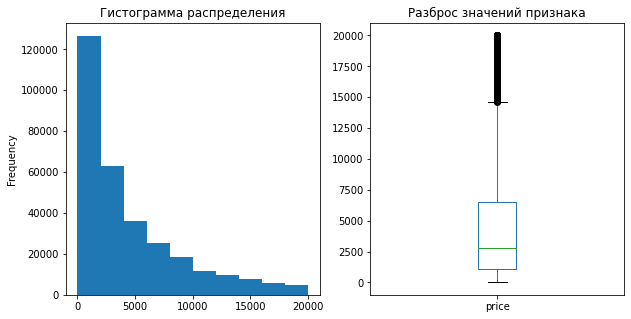

In [23]:
# рассмотрим значения в price
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['price'].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
df['price'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

**Вывод:**
- Гистограмма скошена вправо, распределение имеет положительную асимметрию, большая часть значений приближена к нулю, что не является типичным в контексте определения цены.
- Выбросы указывают, что есть авто с необычно высокими ценами по сравнению с остальной частью набора данных.
- Избавимся от аномальных значений. Установим нижню границу стоимости автомобиля в 500 евро.

In [24]:
# фильтруем данные
df = df[df['price'] > 500]

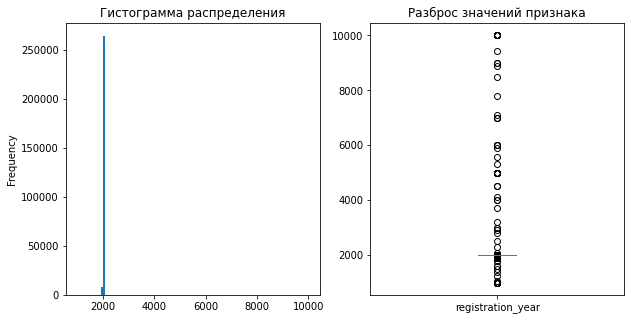

In [25]:
# рассмотрим значения в registration_year
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['registration_year'].plot(kind='hist', bins=100, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
df['registration_year'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

**Вывод:**
- Наблюдается существенный разброс значений, а также выбросы и аномалии.
- Напомним, что данные представлены за 2014 - 2016 гг., значит авто зарегистрированные позднее 2016 года — аномалии.
- Год выпуска может существенно влиять на стоимость авто. Следовало бы уточнить у заказчика детали того, нужно ли включать автомобили ретро класса. В текущих условиях такой возможности нет, поэтому по-умолчанию исключим антикварные авто.
- Руководствуясь классификацией FIVA http://gaz21.ru/articles/misc/180-klassifikacija-avtomobilejj-fiva.html, за нижний порог примем год, который уже не включает раритетные авто. Ограничимся одним процентом.

In [26]:
# вычислим нижний предел для 'registration_year' на основе 1-го процентиля
lower_limit_year = df['registration_year'].quantile(0.01)
lower_limit_year

1979.0

In [27]:
# фильтруем данные
df = df[(df['registration_year'] > 1979) & (df['registration_year'] < 2016)]

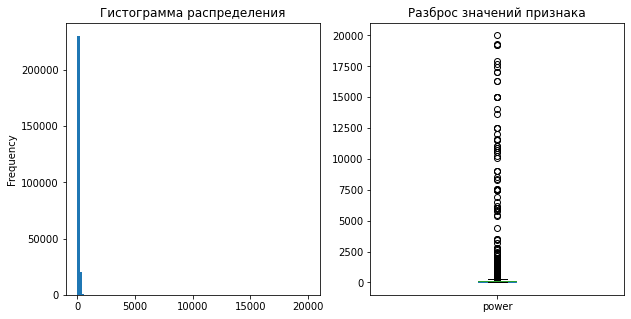

In [28]:
# рассмотрим значения в power
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['power'].plot(kind='hist', bins=100, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
df['power'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

In [29]:
# оценим количество нулевых значений
len(df[df.power == 0])

19626

**Вывод:**
- Согласно графикам, в столбеце довольно много нулевых значений, а также аномально высоких значений мощности.
- Нулевые значения будем учитывать при подготовке данных для обучения модели.
- Верхний порог мощности ограничим 600 л.с., принимая во внимание европейскую классификацию авто https://mafin.ru/media/razbory/evropejskaya-klassifikaciya-avto. Нижний порог установим от 50 л.с.

In [30]:
# фильтруем данные
df = df[(df['power'] > 50) & (df['power'] < 600)]

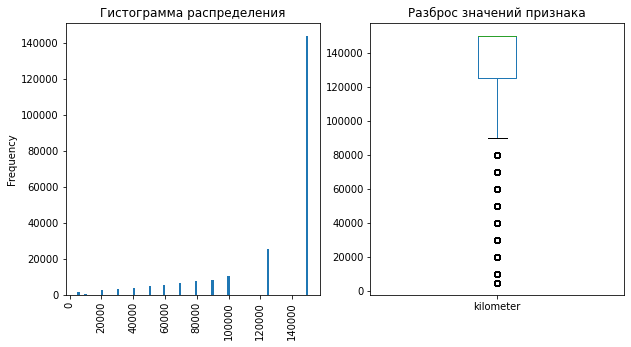

In [31]:
# рассмотрим значения в kilometer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['kilometer'].plot(kind='hist', bins=100, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
axes[0].tick_params(axis='x', rotation=90)
df['kilometer'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

**Вывод:**
- Форма ящика указывает, что большинство значений расположены около 150 тыс. км.
- Диапазон пробега представленных авто колеблется в пределах от 90 до 150 тыс. км.
- Выбросы указывают, что есть экземпляры с исключительно низким пробегом по сравнению с большинством.

Построим гистограммы частотности распределения для каждого признака, чтобы получить наглядное представление о структуре данных, после фильтрации.

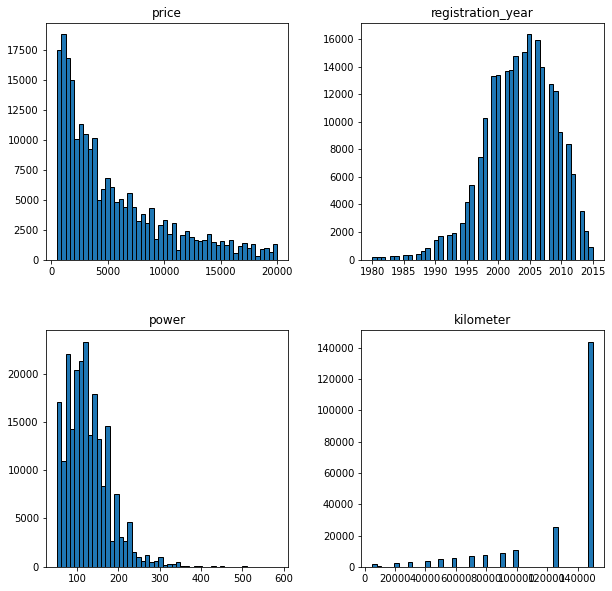

In [32]:
# построим гистограммы после фильтрации
df.hist(bins=50, figsize=(10, 10), edgecolor='black', linewidth=1, grid=False)
plt.show()

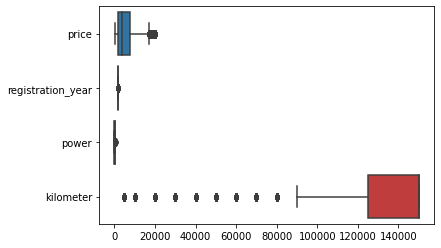

In [33]:
# список числовых признаков таблицы
num_var = df.select_dtypes(include='number').columns.tolist()

# построим диаграмму ящик с усами после фильтрации
sns.boxplot(data=df[num_var], orient='h')
plt.yticks(range(len(num_var)), num_var)
plt.show()

In [34]:
# рассмотрим описательные статистики по числовым столбцам после фильтрации
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
price,225803.0,5411.226144,4664.604878,501.0,1750.0,3800.0,7800.0,20000.0
registration_year,225803.0,2003.360265,5.588844,1980.0,2000.0,2004.0,2007.0,2015.0
power,225803.0,126.863531,53.257198,51.0,90.0,116.0,150.0,585.0
kilometer,225803.0,126673.294863,37384.537357,5000.0,125000.0,150000.0,150000.0,150000.0


**Вывод:**
1. В целом диаграмма показывает, что почти все признаки разного масштаба:
- `price` цена измеряется в евро
- `registration_year` обозначает год регистрации автомобиля
- `power` мощность представлена в лошадиных силах
- `kilometer` пробег авто в километрах
2. Есть выбросы. Это могут быть случаи с необычно высокими и низкими значениями по сравнению с остальной частью набора данных.
3. Все эти особенности будем учитывать при подготовке данных для обучения модели.

**3. Корреляционный анализ признаков**

После обработки данных и до обучения моделей регрессии считаем целесообразным изучить взаимосвязь между признаками.

В ходе исследовательского анализа было обнаружено, что не все признаки распределены нормально, поэтому для оценки взаимосвязи будем использовать корреляцию Phik, который устойчив к выбросам и ненормальному распределению.

In [35]:
# укажем количественные признаки
num_cols = ['price', 'power']

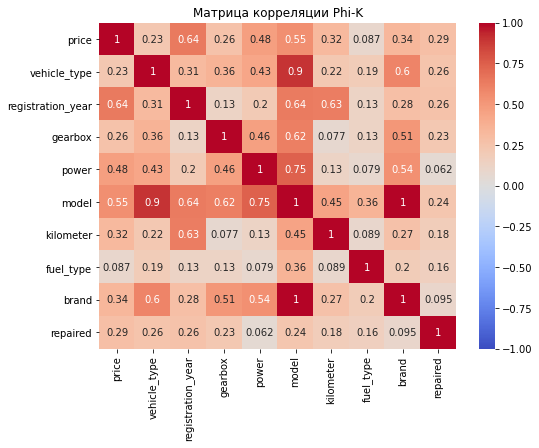

In [36]:
# рассчитаем матрицу корреляции Phi-K между всеми признаками
phik_matrix = df.phik_matrix(interval_cols=num_cols)

# построим heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции Phi-K')
plt.show()

**Вывод:**
- Целевой признак `price` коррелирует с входным `registration_year`, коэффициент корреляции указывают на умеренную положительную связь.
- Менее выраженная связь наблюдается между таргетом и признаками `model` и `power`.
- Остальные входные признаки имеют слабую связь или почти не коррелируют с таргетом.
- Матрица корреляции показывает, что в датасете не обнаружено пар признаков в количественной шкале, которые сильно коррелируют друг с другом, мультиколлинеарности не наблюдается.

## Обучение моделей

**1. Подготовим выборки для обучения моделей.**
Перечислим особенности данных:
- Целевой признак — цена `price`: прогнозируем непрерывный признак.
- Входные признаки `kilometer` и `registration_year` имеют распределение категориального признака, так как задано небольшое количество уникальных значений, значит с ними также стоит работать как с категорией — используем кодирование техникой `OrdinalEncoder`.
- Категориальные признаки: `vehicle_type`, `gearbox`, `fuel_type` и `repaired` — используем кодирование техникой `OneHotEncoder`, это категориальные переменные, в которых нет внутреннего порядка или ранжирования между категориями.
- Категориальные признаки: `model` и `brand` — так как эти переменные содержат большое количество уникальных категорий, использование техники горячего кодирования может привести к большому количеству фиктивных переменных. Поэтому используем технику `FrequencyEncoder` и закодируем каждую категорию на основе её частоты в наборе данных.
- Количественный признак: `power` — масштабируем. Метод масштабирования сделаем гиперпараметром, то есть зададим возможность перебора методов `StandardScaler` и `MinMaxScaler`.

**2. Обучим три модели:**
- LinearRegression()
- DecisionTreeRegressor()
- LGBMRegressor()

**3. Подберём гиперпараметры.**

**4. Оценим точность прогнозов моделей при помощи метрики RMSE.**

Метрика измеряет среднюю величину ошибок между прогнозируемыми и фактическими значениями.

In [37]:
# объявляем константы
RANDOM_STATE = 12345

# списки с названиями признаков
num_columns = ['power']
ord_columns = ['registration_year', 'kilometer']
onehot_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
count_columns = ['model', 'brand']

# трансформер для количественных признаков
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# трансформер для категориальных признаков OrdinalEncoder
ord_transformer = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# трансформер для категориальных признаков OneHotEncoder
onehot_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# трансформер для категориальных признаков CountEncoder
count_transformer = Pipeline([
    ('count', ce.CountEncoder())
])

# общий пайплайн для подготовки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_columns),
        ('ord', ord_transformer, ord_columns),
        ('onehot', onehot_transformer, onehot_columns),
        ('count', count_transformer, count_columns)
    ])

# деление на выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('price', axis=1),
    df['price'],
    test_size=0.25,
    random_state=RANDOM_STATE
)

# преобразование тренировочного набора
X_train_preprocessed = preprocessor.fit_transform(X_train)
# преобразование тестового набора
X_test_preprocessed = preprocessor.transform(X_test)

In [38]:
# опускаем предупреждения
warnings.filterwarnings('ignore')

In [39]:
%%time
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # параметры для Linear Regression
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # параметры для Decision Tree Regressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # параметры для LGBM Regressor
    {
        'models': [LGBMRegressor(boosting_type='gbdt', random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__num_leaves': [30, 50, 70],
        'models__n_estimators': [40, 80, 120],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    verbose=3,
    n_jobs=-1
)
# обучаем модель
randomized_search.fit(X_train, y_train)

# выведем результаты оценки 10 лучших моделей
results = pd.DataFrame(randomized_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(results[['rank_test_score', 'param_models', 'mean_test_score', 'params']]
            .sort_values('rank_test_score').head(10))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,rank_test_score,param_models,mean_test_score,params
8,1,LGBMRegressor(random_state=12345),-1657.313223,"{'preprocessor__num': MinMaxScaler(), 'models__num_leaves': 70, 'models__n_estimators': 120, 'models__learning_rate': 0.05, 'models': LGBMRegressor(random_state=12345)}"
7,2,LGBMRegressor(random_state=12345),-1694.796859,"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 30, 'models__n_estimators': 80, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=12345)}"
2,3,LinearRegression(),-2721.386984,"{'preprocessor__num': MinMaxScaler(), 'models__fit_intercept': False, 'models': LinearRegression()}"
6,4,LGBMRegressor(random_state=12345),-2808.237450,"{'preprocessor__num': MinMaxScaler(), 'models__num_leaves': 70, 'models__n_estimators': 80, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=12345)}"
5,5,LGBMRegressor(random_state=12345),-2808.253953,"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 70, 'models__n_estimators': 80, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=12345)}"
1,6,LGBMRegressor(random_state=12345),-2843.371288,"{'preprocessor__num': 'passthrough', 'models__num_leaves': 50, 'models__n_estimators': 80, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=12345)}"
3,7,LGBMRegressor(random_state=12345),-2902.228640,"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 30, 'models__n_estimators': 80, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=12345)}"
4,8,LGBMRegressor(random_state=12345),-3511.540531,"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 70, 'models__n_estimators': 40, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=12345)}"
0,9,DecisionTreeRegressor(random_state=12345),-4081.775700,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=12345)}"
9,10,DecisionTreeRegressor(random_state=12345),-4596.989090,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 2, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=12345)}"


Wall time: 30 s


## Анализ моделей

1. Проанализируем производительность моделей по критериям: *время обучения*, *время прогноза* и *качество прогноза*.
2. Оценим качество лучшей модели на тестовой выборке.

In [40]:
# вывод соответствующей информации
print("Сравнение моделей:")
print("---------------------------------------------------------------------------------------------------")
print("{:<25} | {:<20} | {:<23} | {:<12} | {:<50}".format("Модель", "Время обучения (сек)", "Время прогноза (сек)", "RMSE оценка", "Гиперпараметры"))
print("---------------------------------------------------------------------------------------------------")

# вывод информации для каждой модели
for i in range(results.shape[0]):
    model_name = results.loc[i, "param_models"].__class__.__name__
    train_time = results.loc[i, "mean_fit_time"]
    pred_time = results.loc[i, "mean_score_time"]
    rmse_score = -results.loc[i, "mean_test_score"]
    hyperparameters = str(results.loc[i, "params"])

    print("{:<25} | {:<20.3f} s | {:<23.3f} s | {:<12.0f} | {:<50}".format(model_name, train_time, pred_time, rmse_score, hyperparameters))

print("---------------------------------------------------------------------------------------------------")

# параметры лучшей модели с учетом прогнозных способностей
best_model_idx = results["mean_test_score"].idxmax()
best_model_params = results.loc[best_model_idx, "params"]
best_model_metric = -results.loc[best_model_idx, "mean_test_score"]

print("\nЛучшая модель:")
print("---------------------------------------------------------------------------------------------------")
print("Параметры:", best_model_params)
print("RMSE оценка: {:.0f}".format(best_model_metric))

Сравнение моделей:
---------------------------------------------------------------------------------------------------
Модель                    | Время обучения (сек) | Время прогноза (сек)    | RMSE оценка  | Гиперпараметры                                    
---------------------------------------------------------------------------------------------------
DecisionTreeRegressor     | 1.051                s | 0.158                   s | 4082         | {'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=12345)}
LGBMRegressor             | 4.323                s | 0.577                   s | 2843         | {'preprocessor__num': 'passthrough', 'models__num_leaves': 50, 'models__n_estimators': 80, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=12345)}
LinearRegression          | 1.660                s | 0.169                   s | 2721         | {'preprocessor__num': MinMaxScaler(), 'mo

In [41]:
# рассмотрим модели с лучшими параметрами: время обучения, время прогноза и качество прогноза
results['model'] = results['param_models'].apply(lambda x: str(x).split('(')[0])
results['mean_test_score'] = -results['mean_test_score']
results[results['mean_test_score'].isin(results.groupby('model')['mean_test_score'].min())][['model', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]

,model,mean_test_score,mean_fit_time,mean_score_time
0,DecisionTreeRegressor,4081.775700,1.050734,0.158077
2,LinearRegression,2721.386984,1.660462,0.169138
8,LGBMRegressor,1657.313223,6.245727,1.020193


In [42]:
# оценка на тестовой выборке
best_model = randomized_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE на тестовой выборке: {test_rmse:.0f}')

RMSE на тестовой выборке: 1632


**Вывод:**
- Из трёх моделей наиболее эффективной с точки зрения **прогнозных способностей** оказалась `LGMRegressor`с гиперпараметрами `num_leaves=70`, `n_estimators=120`, `learning_rate=0.05`, `MinMaxScaler()`.
- Оценка RMSE измеряет среднюю величину ошибок между прогнозируемыми и фактическими значениями. Более низкие значения RMSE указывают на лучшую точность. Значение метрики лучшей модели на **тренировочной** выборке составляет *1657*, что позволяет говорить о хороших прогнозных способностях модели.
- На **тестовой** выборке модель также показывает хорошие результаты по метрике *(1632)*, значит обобщающие способности модели устойчивы и на незнакомых данных.
- По критерию **времени обучения** и **времени прогноза** лидируют `DecisionTreeRegressor` и `LinearRegression`, однако оценки RMSE моделей не позволяют сделать выбор в их пользу. На данных проведённого исследования обе модели показали довольно большую среднюю величину ошибок между прогнозируемыми и фактическими значениями.

## Итоговый вывод

На данных сервиса по продаже автомобилей с пробегом был проведён исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит компании привлечь новых клиентов в контексте разрабатываемого приложения по определению рыночной стоимости авто.

Учитывая бизнес-задачи заказчика предстояло разработать прогнозную модель, которая поможет пользователям приложения определить рыночную стоимость автомобиля.

Работа включала предварительный этап, исследовательский анализ данных, обучение разных моделей с подбором гиперпараметров, анализ моделей по критериям: *время обучения*, *время прогноза* и *качество прогноза*.

На **предварительном этапе** мы изучили основные сведения о датасете с последующей предобработкой, в частности: определили количество и тип данных в таблицах, проверили данные на наличие дубликатов и пропущенных значений, удалили неинформативные признаки, устранили аномалии и убедились, что все данные отображаются корректно.

На этапе **исследовательского анализа** был проведён статистический анализ всех признаков, построены графики и оценены особенности распределения входных и целевых признаков.

Этап **разработки модели** включал подготовку данных для обучения, настройку гиперпараметров, обучение модели оценку качества с использованием метрики RMSE и получение прогнозных значений.

На этапе **анализа моделей** проводилось сопоставление результатов с учётом критериев *времени обучения*, *времени прогноза* и *качества прогноза*.

Учитывая бизнес-задачи заказчика, предстояло разработать прогнозную модель для предсказания стоимости автомобиля (задача линейной регрессии).

Поскольку нам не были известны детальные требования клиента, которые могли бы конкретизировать заказ, в частности, какие есть ресурсные ограничения на разработку модели, мы руководствовались классическими опциями при выборе моделей и алгоритмов обучения. Так, в рамках проекта мы рассмотрели возможности следующих регрессоров:
- `LinearRegression()` — служит базовой или эталонной моделью во время настройки гиперпараметров, чтобы на её основе найти модели, которые работают значительно лучше, чем базовый уровень.
- `DecisionTreeRegressor()` — позволяет фиксировать сложные взаимосвязи в данных, включая нелинейные закономерности.
- `LGBMRegressor()` — использует древовидные алгоритмы обучения с градиентным бустингом, деревья решений строятся таким образом, чтобы оптимизировать уменьшение функции потерь на каждом этапе.

**Основные результаты:**

- Из трёх моделей наиболее эффективной с точки зрения **прогнозных способностей** оказалась `LGMRegressor`с гиперпараметрами `num_leaves=70`, `n_estimators=120`, `learning_rate=0.05`, `MinMaxScaler()`.
- Оценка RMSE измеряет среднюю величину ошибок между прогнозируемыми и фактическими значениями. Более низкие значения RMSE указывают на лучшую точность. Значение метрики лучшей модели на **тренировочной** выборке составляет *1657*, что позволяет говорить о хороших прогнозных способностях модели.
- На **тестовой** выборке модель также показывает хорошие результаты по метрике *(1632)*, значит обобщающие способности модели устойчивы и на незнакомых данных.
- По критерию **времени обучения** и **времени прогноза** лидируют `DecisionTreeRegressor` и `LinearRegression`, однако оценки RMSE моделей не позволяют сделать выбор в их пользу. На данных проведённого исследования обе модели показали довольно большую среднюю величину ошибок между прогнозируемыми и фактическими значениями.
- По временным критериям `LGMRegressor` заняла больше времени для обучения и прогноза по сравнению с `DecisionTreeRegressor` и `LinearRegression` при используемых настройках. Однако, потенциал алгоритма не ограничевается рамками данного исследования.